<a href="https://colab.research.google.com/github/Sarayuma/attrition_detection/blob/main/attrition_detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import shap
import joblib

In [ ]:
# Load the dataset
df = pd.read_csv('/content/hrdata.csv')

In [ ]:
# Preprocessing
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = df.drop(['EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Split data
X = df.drop('Attrition', axis=1)
y = df['Attrition']
print(y)
print(df['Attrition'].value_counts())

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64
Attrition
0    1233
1     237
Name: count, dtype: int64


In [ ]:
# Save feature names
joblib.dump(X.columns, 'feature_names.pkl')

['feature_names.pkl']

In [ ]:
# Handle imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [ ]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc')
lr_grid.fit(X_train_scaled, y_train)
lr_best = lr_grid.best_estimator_

In [ ]:
# Random Forest (MAIN MODEL NOW)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

In [ ]:
# Models dictionary (XGBoost removed)
models = {
    'Logistic Regression': lr_best,
    'Random Forest': rf_best
}

In [ ]:
# Evaluation
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.897
ROC-AUC: 0.953
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       250
           1       0.91      0.87      0.89       244

    accuracy                           0.90       494
   macro avg       0.90      0.90      0.90       494
weighted avg       0.90      0.90      0.90       494


Random Forest Performance:
Accuracy: 0.927
ROC-AUC: 0.970
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       250
           1       0.96      0.89      0.92       244

    accuracy                           0.93       494
   macro avg       0.93      0.93      0.93       494
weighted avg       0.93      0.93      0.93       494



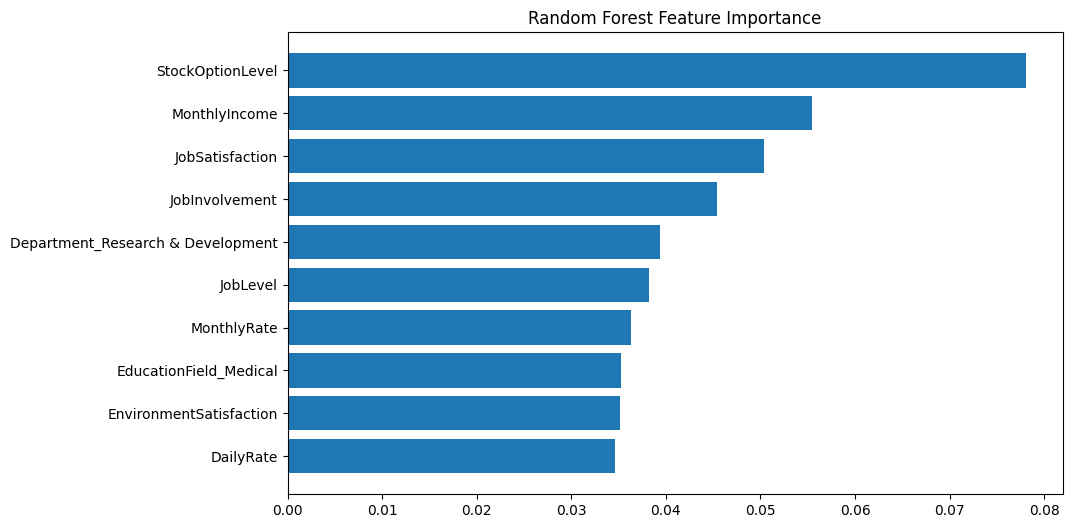

In [ ]:
# FEATURE IMPORTANCE USING RANDOM FOREST
plt.figure(figsize=(10, 6))
sorted_idx = rf_best.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-10:], rf_best.feature_importances_[sorted_idx][-10:])
plt.title("Random Forest Feature Importance")
plt.show()

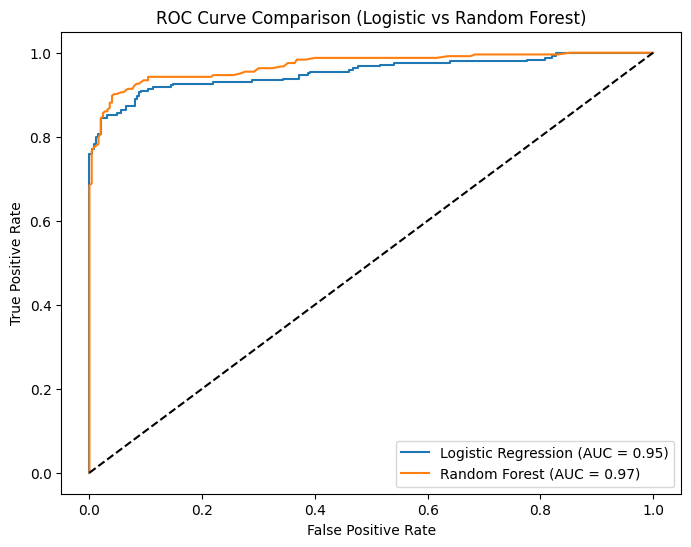

In [ ]:
# ROC CURVE COMPARISON
plt.figure(figsize=(8, 6))

for name, model in models.items():  # models contains only LR + RF now
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Logistic vs Random Forest)')
plt.legend()
plt.show()


In [ ]:
# SAVE RANDOM FOREST AS FINAL MODEL
joblib.dump(rf_best, 'attrition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import pandas as pd
import joblib

model = joblib.load('attrition_model.pkl')
scaler = joblib.load('scaler.pkl')
feature_names = joblib.load('feature_names.pkl')

def predict_attrition():
    print("Enter employee details:")
    age = int(input("Age: "))
    monthly_income = float(input("Monthly Income: "))
    overtime = input("Overtime (Yes/No): ").strip().capitalize()
    job_role = input("Job Role (e.g., 'Sales Executive', 'Research Scientist'): ").strip().capitalize()
    years_at_company = int(input("Years at Company: "))
    job_satisfaction = int(input("Job Satisfaction (1-4): "))

    data = {col: 0 for col in feature_names}

    data['Age'] = age
    data['MonthlyIncome'] = monthly_income
    data['OverTime_Yes'] = 1 if overtime == 'Yes' else 0
    data[f'JobRole_{job_role}'] = 1
    data['YearsAtCompany'] = years_at_company
    data['JobSatisfaction'] = job_satisfaction

    df = pd.DataFrame([data])
    df = df[feature_names]

    scaled_data = scaler.transform(df)

    prediction = model.predict(scaled_data)
    probability = model.predict_proba(scaled_data)[0][1]

    if prediction[0] == 1:
        print(f"\nPrediction: Employee is likely to leave (Probability: {probability:.2%})")
    else:
        print(f"\nPrediction: Employee will stay (Probability: {1 - probability:.2%})")

if __name__ == "__main__":
    predict_attrition()

Enter employee details:
Age: 24
Monthly Income: 100000
Overtime (Yes/No): no
Job Role (e.g., 'Sales Executive', 'Research Scientist'): Research Scientist
Years at Company: 3
Job Satisfaction (1-4): 4

Prediction: Employee is likely to leave (Probability: 63.00%)
